# Brain Metastasis (BM) Radiomics Tutorial

Below are some resources used in this tutorial:
1. [Pretreat-MetsToBrain-Masks](https://www.cancerimagingarchive.net/collection/pretreat-metstobrain-masks/): Dataset from The Cancer Imaging Archive (TCIA) used in this tutorial.
2. [Brain Tumor Segmentation (BraTS) Brain Metastasis Challenge](https://www.synapse.org/#!Synapse:syn51156910/wiki/622553): Where the dataset used in this tutorial comes from, which includes details on preprocessing.
3. [PyRadiomics](https://github.com/AIM-Harvard/pyradiomics): For extracting radiomics features from NIfTI image and segmentation files.
4. [Foundation Model for Cancer Imaging Biomarkers (FMCIB)](https://github.com/AIM-Harvard/foundation-cancer-image-biomarker): For extracting features based on pre-trained foundation model from NIfTI image files given segmentation seed points.

## Imports

In [26]:
# General
import os
from urllib.request import urlretrieve
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler

# PyRadiomics
import radiomics
radiomics.setVerbosity(60)

# FMCIB
from fmcib.run import get_features
from fmcib.visualization import visualize_seed_point

## Constants

In [10]:
# TCIA links
tcia_url = "https://www.cancerimagingarchive.net/wp-content/uploads/"
clin_file = "Pretreat-MetsToBrain-Masks_clin_20230918.xlsx"

# Define directory paths
out_dir = "/Users/mitchellparker/Pretreat-MetsToBrain-Masks"
brats_dir = "/Users/mitchellparker/PKG - Pretreat-MetsToBrain-Masks/Pretreat-MetsToBrain-Masks"

# Define file names
rad_path = os.path.join(out_dir, "Radiomics.csv")
fmcib_path = os.path.join(out_dir, "FMCIB.csv")

# Make output directory
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    
# Specify file paths
clin_path = os.path.join(out_dir, clin_file)

## Table of Contents

1. Prepare BM Dataset from TCIA
2. Extract PyRadiomics Features from NIfTI Files
3. Extract FMCIB Features from NIfTI Files
4. Predict Outputs Based On Radiomic Features

## 1. Prepare BM Dataset from TCIA

### 1.1 Clinical Data

In [11]:
# Download clinical file from TCIA
## urlretrieve(tcia_url + clin_file, clin_path)

# Display clinical data (Note: see description sheet for column definitions)
clin_df = pd.read_excel(clin_path, sheet_name="Data")

# Limit to cases with 1 lesion
clin_df = clin_df[clin_df["ET_num"].isin([1])]

# Print total cases
print("Total Cases:", len(clin_df))

# Display data
clin_df.head()

Total Cases: 67


,BraTS_MET_ID,Age,Sex,Ethnicity,Smoke,Primary,Extranodal,Survival,Death,Infratentorial,ET_num,Nec_num,Edema_num,ET_vol,Nec_vol,Edema_vol,Nec_ET_ratio,Edema_ET_ratio
1,89,56.958904,1,0,9.0,4,1.0,21.266667,1.0,0,1,0,1,0.487,0.000,0.267,0.000000,0.548255
5,98,64.947945,0,0,40.0,6,1.0,41.466667,0.0,0,1,0,1,0.205,0.000,17.380,0.000000,84.780488
8,104,61.706849,1,3,0.0,2,0.0,4.466667,1.0,0,1,1,1,2.619,1.807,64.363,0.408269,14.542024
10,106,71.575342,1,0,30.0,3,0.0,53.433333,0.0,1,1,0,1,0.132,0.000,0.266,0.000000,2.015152
11,107,74.972603,0,0,15.0,6,1.0,7.700000,0.0,0,1,0,1,0.135,0.000,0.199,0.000000,1.474074


### 1.2 Imaging Data

In [12]:
# Download files from https://faspex.cancerimagingarchive.net/aspera/faspex/public/package?context=eyJyZXNvdXJjZSI6InBhY2thZ2VzIiwidHlwZSI6ImV4dGVybmFsX2Rvd25sb2FkX3BhY2thZ2UiLCJpZCI6Ijc0NiIsInBhc3Njb2RlIjoiZmQzZGRmYjA1YjA1ZjNhMTBlZDExMmY4NTJhM2Y0YTlmMzBlODY1MSIsInBhY2thZ2VfaWQiOiI3NDYiLCJlbWFpbCI6ImhlbHBAY2FuY2VyaW1hZ2luZ2FyY2hpdmUubmV0In0=&redirected=true

# Define functions 
def get_case_str(case_id): # Get case string from case ID
    return "BraTS-MET-" + "0"*(5-len(case_id)) + case_id + "-000"
def get_case_path(case_id): # Get path to folder with case NIfTI files
    return os.path.join(brats_dir, get_case_str(case_id))
def get_nifti_path(case_id, file_str): # Get path of NIfTI file based on case ID and string within the file (i.e., t1c, t1n, etc.)
    case_str = get_case_str(case_id)
    return os.path.join(get_case_path(case_id), f"{case_str}-{file_str}.nii.gz")

# Set empty lists to put case ID and NIfTI paths
case_id_list = []

t1c_path_list = []
t1n_path_list = []
t2f_path_list = []
t2w_path_list = []
seg_path_list = []

# Loop through clinical data and get paths to all NIfTI files
for _, row in clin_df.iterrows():
    case_id = str(row["BraTS_MET_ID"])

    case_id_list.append(case_id)
    t1c_path_list.append(get_nifti_path(case_id, "t1c"))
    t1n_path_list.append(get_nifti_path(case_id, "t1n"))
    t2f_path_list.append(get_nifti_path(case_id, "t2f"))
    t2w_path_list.append(get_nifti_path(case_id, "t2w"))
    seg_path_list.append(get_nifti_path(case_id, "seg"))

## 3. Extract PyRadiomics Features from NIfTI Files

### 3.1 Run PyRadiomics Pipeline and Build Dataframe for FMCIB

In [50]:
# Specify list of radiomic features to include
rad_feature_list = ["shape", "firstorder", "glcm", 
                "gldm", "glrlm", "glszm", "ngtdm"]

# Instantiate PyRadiomics and tell it to extract features from label 3, which is the enhancing tumor
extractor = radiomics.featureextractor.RadiomicsFeatureExtractor(label=3)

# Make empty dataframe to add radiomic data as well as a dataframe to save for running FMCIB
rad_df = pd.DataFrame()
fmcib_df = pd.DataFrame()

# Loop through cases
for i, case_id in enumerate(tqdm(case_id_list)):

    # Get index of case ID
    i = case_id_list.index(case_id)

    # Get segmentation path
    seg_path = seg_path_list[i]

    # Make data dictionary to store radiomic features
    rad_data = []
    fmcib_data = []

    # Loop through image sequences
    for img_path_list, img_str in zip([t1c_path_list, t1n_path_list,
                              t2f_path_list, t2w_path_list], 
                             ["t1c", "t1n", "t2f", "t2w"]):

        # Get image path
        img_path = img_path_list[i]
        
        # Extract radiomic features
        img_rad = extractor.execute(img_path, seg_path)

        # Get center of mass
        com = img_rad["diagnostics_Mask-original_CenterOfMass"]

        # Add PyRadiomics data
        rad_data.append({"BraTS_MET_ID": case_id, 
                              "image_sequence": img_str} | {k: v for k, v in img_rad.items() if any(x in k for x in rad_feature_list)})

        # Add FMCIB data
        fmcib_data.append({"BraTS_MET_ID": case_id,
                                "image_sequence": img_str,
                                "image_path": img_path,
                                "label_path": seg_path,
                                "coordX": com[0],
                                "coordY": com[1],
                                "coordZ": com[2]
                               })

    # Make into dataframes and concatinate to the dataset
    case_rad_df = pd.DataFrame(rad_data)
    rad_df = pd.concat([rad_df, case_rad_df])

    case_fmcib_df = pd.DataFrame(fmcib_data)
    fmcib_df = pd.concat([fmcib_df, case_fmcib_df])

100%|███████████████████████████████████████████| 67/67 [02:41<00:00,  2.41s/it]


### 3.2 Display PyRadiomics Data

In [52]:
# Save and display data
rad_df = rad_df.reset_index(drop=True) # Reset index
rad_df.to_csv(rad_path, index=False) # Save
rad_df.head() # Display

,BraTS_MET_ID,image_sequence,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,89,t1c,0.830477,0.573060,6.528431,11.39222,12.36931687685298,11.180339887498949,12.649110640673518,13.416407864998739,...,168.59443230617467,0.03040024110612478,6.004930131122682,0.3490759753593429,28.999342560553632,0.11197997739033022,0.014899318135910783,1011.3882952790201,0.37584852230307086,4.803546780639607
1,89,t1n,0.830477,0.573060,6.528431,11.39222,12.36931687685298,11.180339887498949,12.649110640673518,13.416407864998739,...,1.616924130673743,0.1893143866931447,3.4182958340544856,0.024640657084188913,4674.57638888889,1.3796177612544358,0.019130518386623187,8.32131221724822,0.01823035348470802,0.34944548554875404
2,89,t2f,0.830477,0.573060,6.528431,11.39222,12.36931687685298,11.180339887498949,12.649110640673518,13.416407864998739,...,22.096604146363322,0.04147076312557595,4.648955904159985,0.07392197125256673,782.971450617284,0.2510530930381886,0.023197033381813562,62.17773823742052,0.029475320077493095,2.1343141757481514
3,89,t2w,0.830477,0.573060,6.528431,11.39222,12.36931687685298,11.180339887498949,12.649110640673518,13.416407864998739,...,226.3144849212587,0.014631338877010585,6.019056590212617,0.34291581108829566,40.48399010362509,0.13092062655180853,0.0226922909459303,1295.7426190949338,0.15313803882610127,18.246050634299447
4,98,t1c,0.932648,0.858528,6.349547,7.39585,10.0,9.219544457292887,10.198039027185569,10.198039027185569,...,114.88238970200875,0.022051941455898758,5.073355201761269,0.5365853658536586,6.172314049586777,0.10273208458822435,0.0318035469627407,652.6967379439708,0.4561191260249009,6.877852438034535


### 3.3 Display FMCIB Table

In [53]:
# Save and display data
fmcib_df = fmcib_df.reset_index(drop=True) # Reset index
fmcib_df.to_csv(fmcib_path, index=False) # Save
fmcib_df.head() # Display

,BraTS_MET_ID,image_sequence,image_path,label_path,coordX,coordY,coordZ
0,89,t1c,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,-98.960986,-427.168378,91.833676
1,89,t1n,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,-98.960986,-427.168378,91.833676
2,89,t2f,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,-98.960986,-427.168378,91.833676
3,89,t2w,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,-98.960986,-427.168378,91.833676
4,98,t1c,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,-141.448780,-345.195122,99.624390


## 4. Extract FMCIB Features from NIfTI Files

### 4.1 Visualize Seed Point for Correctness

In [57]:
# Load FMCIB data
fmcib_df = pd.read_csv(fmcib_path)

Segmentation - Label Map


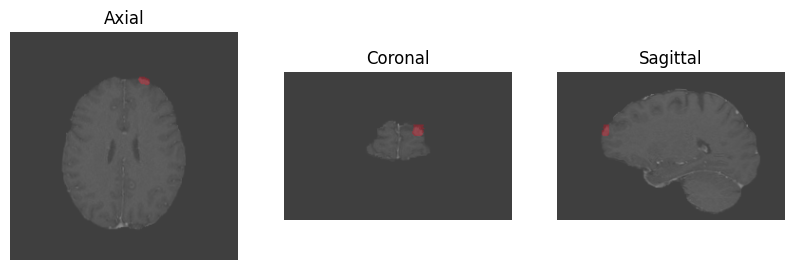

Seed Point - Bounding Box


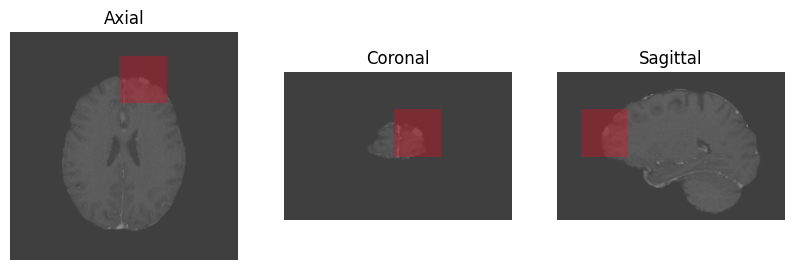

In [58]:
# Get image at index
row_df = fmcib_df.loc[0]

# Display label map by segmentation
print("Segmentation - Label Map")
visualize_seed_point(row_df)

# Display bounding box by seed point ([50, 50, 50] determined by XYZ coordinates)
print("Seed Point - Bounding Box")
del row_df["label_path"]
visualize_seed_point(row_df)

### 4.2 Run FMCIB On Dataset

In [59]:
fmcib_df = get_features(fmcib_path, num_workers=0, batch_size=1) # Run FMCIB
fmcib_df.to_csv(fmcib_path, index=False) # Save
fmcib_df.head() # Display

2024-04-12 12:24:23.342 | INFO     | fmcib.run:get_features:25 - Loading CSV file ...
2024-04-12 12:24:23.351 | INFO     | fmcib.preprocessing:get_dataloader:48 - Building dataloader instance ...
2024-04-12 12:24:26.785 | WARNING  | fmcib.models.load_model:load:104 - Missing keys: [] and unexpected keys: []
2024-04-12 12:24:26.791 | INFO     | fmcib.models.load_model:load:129 - Loaded pretrained model weights 

2024-04-12 12:24:26.807 | INFO     | fmcib.run:get_features:47 - Running inference over batches ...
100%|█████████████████████████████████████████| 268/268 [01:57<00:00,  2.28it/s]


,BraTS_MET_ID,image_sequence,image_path,label_path,coordX,coordY,coordZ,pred_0,pred_1,pred_2,...,pred_4086,pred_4087,pred_4088,pred_4089,pred_4090,pred_4091,pred_4092,pred_4093,pred_4094,pred_4095
0,89,t1c,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,-98.960986,-427.168378,91.833676,1.588058,1.568381,1.306961,...,1.561199,0.659168,0.940229,1.272532,1.077139,1.050761,0.051671,0.888978,0.232324,1.333418
1,89,t1n,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,-98.960986,-427.168378,91.833676,1.476679,1.429372,1.358873,...,1.459644,0.567511,1.048605,1.470391,1.454171,0.956991,0.178822,0.708560,0.210116,0.894501
2,89,t2f,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,-98.960986,-427.168378,91.833676,1.521786,1.617787,1.324050,...,1.581203,0.445389,1.050603,1.517578,1.299671,0.898349,0.213216,0.813498,0.066743,1.123521
3,89,t2w,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,-98.960986,-427.168378,91.833676,1.291364,0.688020,0.642624,...,1.819262,1.588707,1.462942,0.459343,0.581212,0.640272,1.551088,0.549497,0.096123,0.798825
4,98,t1c,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,/Users/mitchellparker/PKG - Pretreat-MetsToBra...,-141.448780,-345.195122,99.624390,1.957341,1.387756,1.083936,...,0.315013,0.775838,2.576335,1.641487,1.117426,1.054924,0.349373,1.565805,1.280373,2.620979


## 5. Predict Outputs Based On Radiomic Features

### 5.1 Mege Datasets

In [64]:
# Load data
clin_df = pd.read_excel(clin_path, sheet_name="Data") # Clinical
rad_df = pd.read_csv(rad_path) # Radiomics
fmcib_df = pd.read_csv(fmcib_path) # FMCIB

# Limit to cases with 1 lesion
clin_df = clin_df[clin_df["ET_num"].isin([1])]

# Make copies of dataframes to add radiomics and FMCIB data to
clin_rad_df = clin_df.copy()
clin_fmcib_df = clin_df.copy()
clin_rad_fmcib_df = clin_df.copy()

# Get list of feature columns in FMCIB dataset
rad_col_list = [x for x in rad_df.columns if x not in ["BraTS_MET_ID", "image_sequence"]]
fmcib_col_list = [x for x in fmcib_df.columns if "pred" in x]

# Loop through image sequences in FMCIB data
for seq in list(rad_df["image_sequence"].unique()):

    # Get subset of FMCIB data for the image sequence
    seq_rad_df = rad_df[rad_df["image_sequence"].isin([seq])]
    seq_fmcib_df = fmcib_df[fmcib_df["image_sequence"].isin([seq])]

    # Make dictionary to rename features columns
    rad_rename_dict = {x: x + "_" + seq for x in rad_col_list}
    fmcib_rename_dict = {x: x + "_" + seq for x in fmcib_col_list}

    # Rename columns to feature + sequence
    seq_rad_df = seq_rad_df.rename(columns=rad_rename_dict)
    seq_fmcib_df = seq_fmcib_df.rename(columns=fmcib_rename_dict)

    # Limit FMCIB data to ID and feature columns
    seq_rad_df = seq_rad_df.loc[:, ["BraTS_MET_ID"] + [rad_rename_dict[x] for x in rad_col_list]]
    seq_fmcib_df = seq_fmcib_df.loc[:, ["BraTS_MET_ID"] + [fmcib_rename_dict[x] for x in fmcib_col_list]]

    # Merge with final dataset
    clin_rad_df = clin_rad_df.merge(seq_rad_df, on="BraTS_MET_ID")
    clin_fmcib_df = clin_fmcib_df.merge(seq_fmcib_df, on="BraTS_MET_ID")

    clin_rad_fmcib_df = clin_rad_fmcib_df.merge(seq_rad_df, on="BraTS_MET_ID")
    clin_rad_fmcib_df = clin_rad_fmcib_df.merge(seq_fmcib_df, on="BraTS_MET_ID")
    
# Display complete data
print("Clinical:", len(clin_df.columns) - 1)
print("Clinical + Radiomics:", len(clin_rad_df.columns) - 1)
print("Clinical + FMCIB:", len(clin_fmcib_df.columns) - 1)
print("Clinical + Radiomics + FMCIB:", len(clin_rad_fmcib_df.columns) - 1)

Clinical: 17
Clinical + Radiomics: 445
Clinical + FMCIB: 16401
Clinical + Radiomics + FMCIB: 16829


### 5.2 Visualize UMAP of FMCIB Features by Image Sequence

ValueError: keyword leftlabel is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

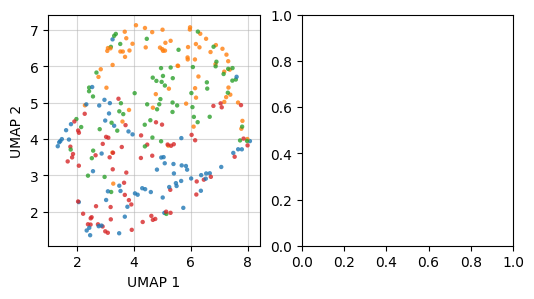

In [116]:
# Function to plot UMAP
def plot_umap(df, col_list, hue_col, norm_data=True,
              color_palette="tab10", 
              x_label="UMAP 1",
              y_label="UMAP 2",
              show_x_ticks=False,
              show_y_ticks=False,
              plot_title=None,
              legend_title="Feature",
              show_legend="auto",
              legend_loc="center left",
              legend_bbox=(1, 0.5),
              legend_markerscale=1.5,
              legend_ncols=1,
              show_ticks=False,
              show_grid=True,
              marker_size=10,
              marker_linewidth=0,
              alpha=0.8,
              ax=None):

    # Make a copy of the dataframe
    u_df = df.copy()

    # Get list of hues and map to colors
    hue_list = list(u_df[hue_col].unique())
    hue_map_dict = dict(zip(hue_list, list(range(len(hue_list)))))
    c = [sns.color_palette("tab10")[x] for x in u_df[hue_col].map(hue_map_dict)]

    # Get just features
    u_data = u_df[col_list].values

    # Step to Z-score normalize data if neded
    if norm_data:
        u_data = StandardScaler().fit_transform(u_data)
    
    fit = umap.UMAP()
    u = fit.fit_transform(u_data)

    g = sns.scatterplot(
        x=u[:, 0],
        y=u[:, 1],
        hue=u_df[hue_col].to_list(),
        palette=color_palette,
        legend=show_legend,
        zorder=2,
        linewidth=marker_linewidth,
        s=marker_size,
        alpha=alpha,
        ax=ax)

    if x_label is not None:
        g.set_xlabel(x_label)
    if y_label is not None:
        g.set_ylabel(y_label)

    if show_grid:
        g.grid(axis="both", linestyle="-", zorder=1, alpha=0.5)

    if not show_ticks:
        g.tick_params(left=False, bottom=False, leftlabel=show_x_ticks, bottomlabel=show_y_ticks)

    if plot_title is not None:
        g.set_title(plot_title)
    
    if show_legend != False:
        g.legend(title=legend_title, 
                 loc=legend_loc, 
                 bbox_to_anchor=legend_bbox, 
                 markerscale=legend_markerscale,
                 ncols=legend_ncols)

    return g

fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(6, 3))
ax1 = plot_umap(rad_df, 
                col_list=rad_col_list, 
                hue_col="image_sequence", 
                plot_title="Radiomics", 
                show_legend=False, 
                ax=axs[0])
ax3 = plot_umap(fmcib_df, 
                col_list=fmcib_col_list, 
                hue_col="image_sequence", 
                y_label=None,
                plot_title="FMCIB", 
                legend_title="Image Sequence", 
                legend_ncols=2,
                ax=axs[1])

plt.show()